# Stock Movement Explanation Agent (Multi-Agent, Tools, Memory, Context Engineering)

This notebook is my submission for the **Agents Intensive Capstone**.

## Goal

Build an **LLM-powered multi-agent system** that can:

- Explain **why a stock’s price moved** over a given date range.
- Use:
  - Historical **price data** (from `yfinance`)
  - **Technical analysis** (volatility, largest daily moves)
  - **Market/sector context** (SPY + XLK)
  - **Quarterly income statements** (revenue, net income)
- Support **conversational follow-ups** like:
  - “Explain MSFT from 2024-01-01 to 2024-02-01”
  - “How about from 2024-02-01 to 2024-03-01?”
  - “Now do NVDA for last month”

## Concepts Demonstrated

This notebook demonstrates **at least 3 key course concepts** (in fact, more):

1. **Multi-Agent System (Sequential Agents)**
   - Orchestrator Agent
   - Price Agent
   - Technical Agent
   - Market Context Agent
   - Financials Agent
   - Parser Agent

2. **Custom Tools**
   - `fetch_prices_yf` — OHLCV prices via `yfinance`
   - `analyze_technicals` — volatility, largest move, trend
   - `summarize_market_context_yf` — SPY & XLK benchmark comparison
   - `fetch_quarterly_income_yf` — quarterly income statements via `yfinance`

3. **Agent Powered by LLM**
   - All agents use **Gemini 2.0** and **Gemini 2.5** models via `google-genai`

4. **Conversational Memory**
   - Uses *InMemoryRunner* to maintain conversational flow 

5. **Context Engineering**
   - Separate system prompts per sub-agent
   - Orchestrator receives structured text outputs + raw JSON blocks

6. **(Optional) Observability & Evaluation**
   - Easy to plug in logging & evaluation (see end of notebook for optional section).

## Architecture

The system uses:

- A **Natural Language Parser Agent** to extract ticker & date ranges
- A **sequential multi-agent pipeline**:
  1. Price Agent -> `fetch_prices_yf`
  2. Technical Agent -> `analyze_technicals`
  3. Market Agent -> `summarize_market_context_yf`
  4. Financials Agent -> `fetch_quarterly_income_yf`
  5. Orchestrator Agent -> synthesize final explanation

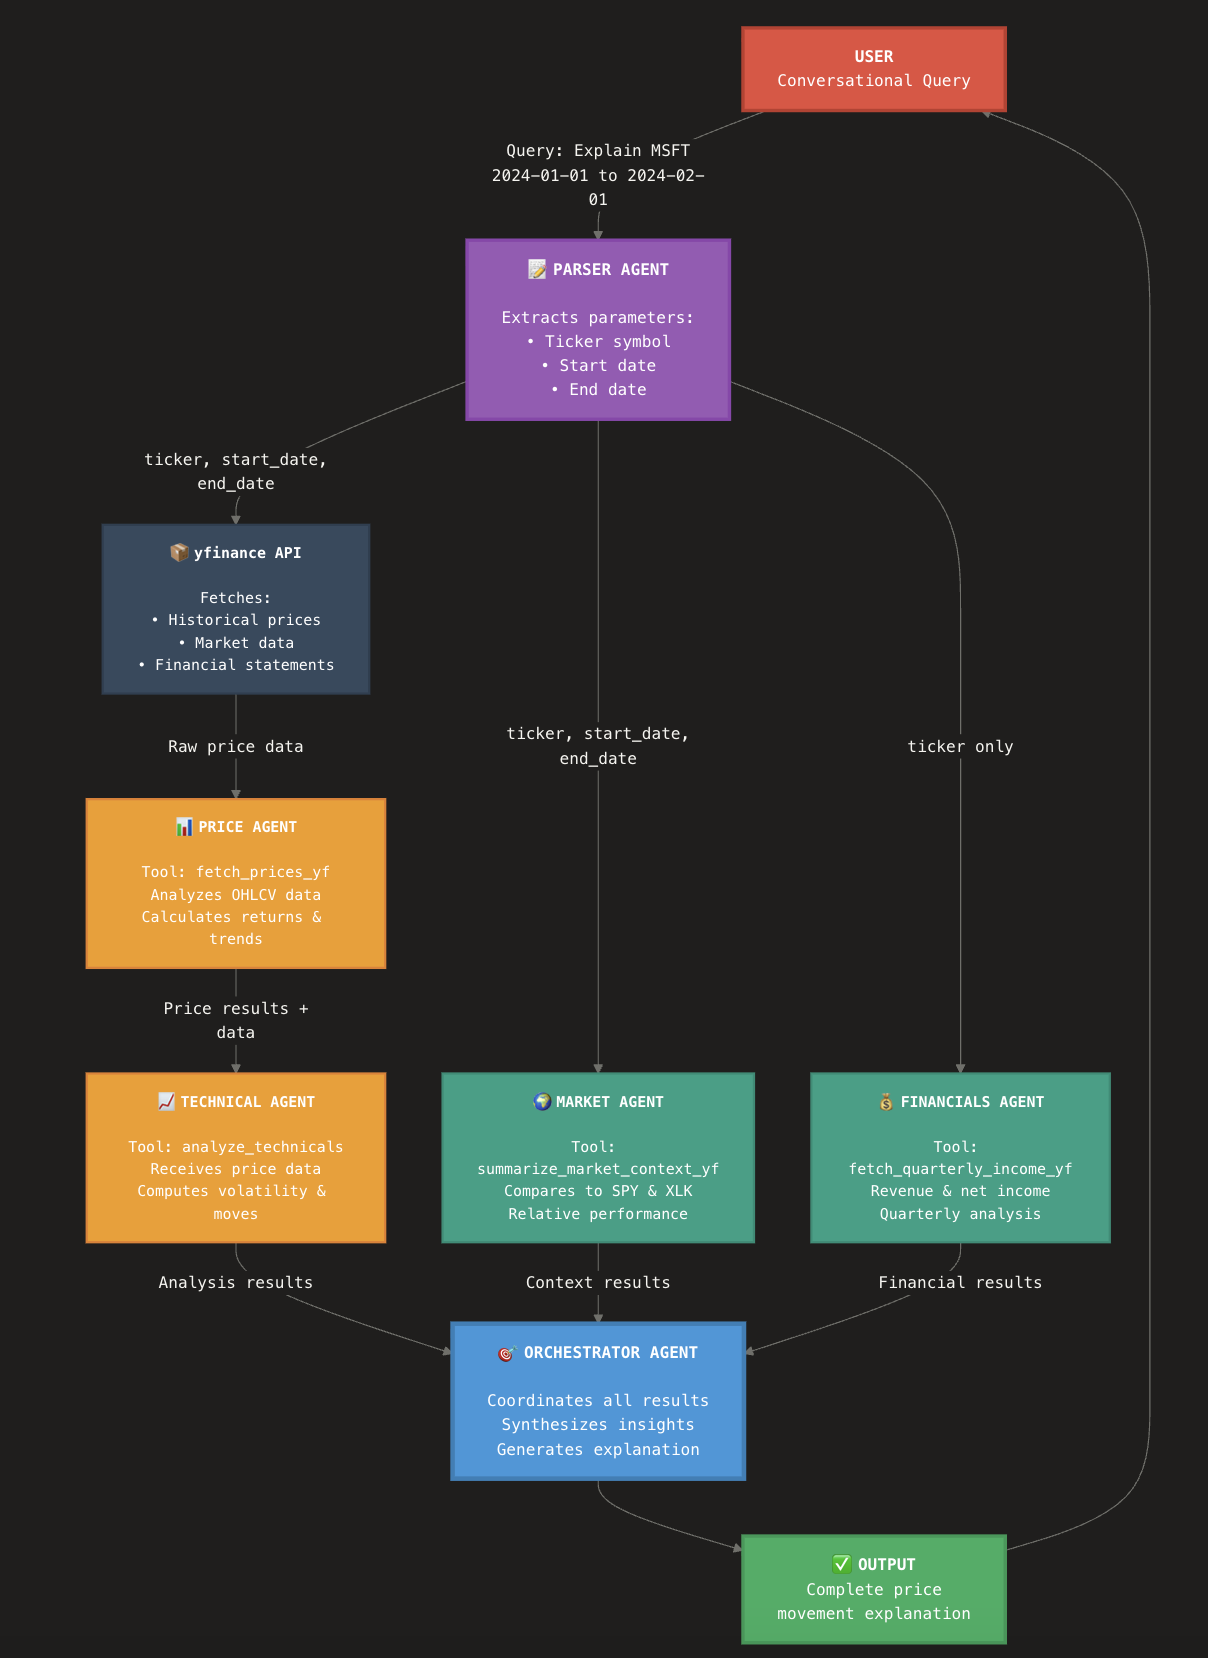

In [1]:
## Creating the architecture diagram 
from IPython.display import Image, display

display(Image(filename='/kaggle/input/stock-agent-workflow/multi-agent-workflow.png'))

## Setup & Imports

In [2]:
## Installing the yahoo finance package
!pip install yfinance

In [3]:
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.runners import InMemoryRunner
from google.genai import types
import os
from datetime import datetime
import statistics as stats
from typing import Any, Dict, List
import yfinance as yf
import pandas as pd


print("✅ ADK components and packages imported successfully.")

✅ ADK components and packages imported successfully.


In [4]:
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}")

✅ Gemini API key setup complete.


## Utility Functions

In [5]:
def _fmt_date(d: str) -> str:
    """Ensure date is in YYYY-MM-DD format."""
    return datetime.strptime(d, "%Y-%m-%d").strftime("%Y-%m-%d")

def _safe_float(x: Any) -> float:
    try:
        return float(x)
    except Exception:
        return 0.0

def _ratio(a: float, b: float) -> float:
    """Return (a/b - 1) safely."""
    a = _safe_float(a)
    b = _safe_float(b)
    if b == 0:
        return 0.0
    return (a / b) - 1.0

## Tools Functions

#### Price Stool

In [6]:
def fetch_prices_yf(ticker: str, start_date: str, end_date: str) -> Dict[str, Any]:
    import pandas as pd

    start = _fmt_date(start_date)
    end = _fmt_date(end_date)

    data = yf.download(ticker, start=start, end=end)

    if data.empty:
        return {"ticker": ticker, "start": start, "end": end, "prices": []}

    # Reset index so dates become a column
    data = data.reset_index()

    # FLATTEN tuple columns
    def flatten_col(col):
        if isinstance(col, tuple):
            return col[0]  # use the first part ("Open", "High", "Date", etc.)
        return col

    data.columns = [flatten_col(c) for c in data.columns]

    # Create clean date column
    data["date"] = pd.to_datetime(data["Date"]).dt.strftime("%Y-%m-%d")

    # Extract JSON-safe OHLCV rows
    records = (
        data[["date", "Open", "High", "Low", "Close", "Volume"]]
        .rename(
            columns={
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Volume": "volume",
            }
        )
        .to_dict(orient="records")
    )

    return {
        "ticker": ticker,
        "start": start,
        "end": end,
        "prices": records,
    }

#### Market Context Tool

In [7]:
def summarize_market_context_yf(
    ticker: str, start_date: str, end_date: str
) -> Dict[str, Any]:
    """
    Compare the analysis window vs SPY (market) and XLK (sector proxy).
    Returns:
      {
        "market_symbol": "SPY",
        "market_pct_change": float,
        "sector_symbol": "XLK",
        "sector_pct_change": float
      }
    """
    start = _fmt_date(start_date)
    end = _fmt_date(end_date)

    def pct_change(symbol: str) -> float:
        d = yf.download(symbol, start=start, end=end)
        if d.empty or len(d) < 2:
            return 0.0
        return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)

    return {
        "market_symbol": "SPY",
        "market_pct_change": pct_change("SPY"),
        "sector_symbol": "XLK",
        "sector_pct_change": pct_change("XLK"),
    }

#### Technical Analysis Tool

In [8]:
def analyze_technicals(price_data: Dict[str, Any]) -> Dict[str, Any]:
    """
    Compute overall return, volatility, and largest single-day move.
    Returns ratios (0.05 = +5%).
    """
    prices: List[Dict[str, Any]] = price_data.get("prices", [])
    if len(prices) < 2:
        return {
            "overall_pct": 0.0,
            "volatility": 0.0,
            "max_move": None,
            "n_days": len(prices),
        }

    closes = [p["close"] for p in prices]
    dates = [p["date"] for p in prices]

    daily_returns: List[float] = []
    max_idx = 1
    max_abs = -1.0

    for i in range(1, len(closes)):
        r = _ratio(closes[i], closes[i - 1])
        daily_returns.append(r)
        if abs(r) > max_abs:
            max_abs = abs(r)
            max_idx = i

    overall_pct = _ratio(closes[-1], closes[0])
    volatility = float(stats.pstdev(daily_returns)) if len(daily_returns) > 1 else 0.0

    max_move = {
        "date": dates[max_idx],
        "pct": daily_returns[max_idx - 1] if max_idx - 1 < len(daily_returns) else 0.0,
    }

    return {
        "overall_pct": float(overall_pct),
        "volatility": volatility,
        "max_move": max_move,
        "n_days": len(prices),
    }

#### Financial Tool

In [9]:
def fetch_quarterly_income_yf(ticker: str) -> Dict[str, Any]:
    """
    Fetch quarterly income statement using yfinance.
    Returns:
      {
        "ticker": str,
        "financials": [
          {
            "metric": str,
            "quarters": [
              {"quarter": "YYYY-MM-DD", "value": float}, ...
            ]
          }, ...
        ]
      }
    """
    t = yf.Ticker(ticker)
    df = t.quarterly_financials

    if df is None or df.empty:
        return {"ticker": ticker, "financials": []}

    df = df.fillna(0)
    financials: List[Dict[str, Any]] = []

    for metric in df.index:
        row = {"metric": str(metric), "quarters": []}
        for col in df.columns:
            if hasattr(col, "date"):
                q_date = col.date().isoformat()
            else:
                q_date = str(col)
            value = _safe_float(df.loc[metric, col])
            row["quarters"].append({"quarter": q_date, "value": value})
        financials.append(row)

    return {"ticker": ticker, "financials": financials}


## Defining All the Sub-Agents

#### Parser Agent

In [10]:
parser_agent = Agent(
    name="ParserAgent",
    model="gemini-2.0-flash",
    instruction="""
Extract a stock query into structured JSON.

Rules:
- NO commentary, no text, no bullet points.
- ONLY return a JSON object.
- Keys: ticker, start_date, end_date.
- Dates must be in YYYY-MM-DD format.
- If date missing, return null.
- If ticker missing, return null.

Example output:
{"ticker": "MSFT", "start_date": "2024-01-01", "end_date": "2024-02-01"}
""",
    output_key="parsed",
)

#### Price Agent

In [11]:
price_agent = Agent(
    name="PriceAgent",
    model="gemini-2.5-flash-lite",
    instruction="""
You are the Price Agent.

Your job:
- Call fetch_prices_yf(ticker, start_date, end_date)
- Summarize:
    * first/last close
    * % change
    * trading days
- Return a natural-language summary + RAW_PRICE_JSON.
""",
    tools=[fetch_prices_yf],
    output_key="price_output",
)

#### Techincal Agent

In [12]:
technical_agent = Agent(
    name="TechnicalAgent",
    model="gemini-2.5-flash-lite",
    instruction="""
You are the Technical Agent.

Input:
- RAW_PRICE_JSON from Price Agent

Your job:
- Call analyze_technicals(RAW_PRICE_JSON)
- Summarize trend, volatility, biggest move
- Return summary + RAW_TECHNICAL_JSON
""",
    tools=[analyze_technicals],
    output_key="technical_output",
)

#### Market Context Agent

In [13]:
market_agent = Agent(
    name="MarketAgent",
    model="gemini-2.5-flash-lite",
    instruction="""
You are the Market Agent.

Your job:
- Call summarize_market_context_yf(ticker, start_date, end_date)
- Compare the ticker vs SPY and XLK
- Return summary + RAW_MARKET_JSON
""",
    tools=[summarize_market_context_yf],
    output_key="market_output",
)

#### Financials Agent

In [14]:
financials_agent = Agent(
    name="FinancialsAgent",
    model="gemini-2.5-flash-lite",
    instruction="""
You are the Financials Agent.

Your job:
- Call fetch_quarterly_income_yf(ticker)
- Summarize revenue/net income trends
- Return summary + RAW_FINANCIAL_JSON
""",
    tools=[fetch_quarterly_income_yf],
    output_key="financial_output",
)

#### Orchestrator Agent

In [15]:
orchestrator_agent = Agent(
    name="OrchestratorAgent",
    model="gemini-2.5-flash-lite",
    instruction="""
You are the Orchestrator Agent.

You receive:
- price_output
- technical_output
- market_output
- financial_output

Your job:
- Combine everything
- Produce final explanation:
    * Movement summary
    * Technical drivers
    * Market context
    * Financial backdrop
    * Confidence level
    * Evidence list

- The final explanation should be text only.
""",
    tools=[],
    output_key="final_explanation",
)

## Sequential Agent

In [16]:
root_agent = SequentialAgent(
    name="StockExplanationSystem",
    sub_agents=[
        parser_agent,
        price_agent,
        technical_agent,
        market_agent,
        financials_agent,
        orchestrator_agent,
    ],
)

## Conversational Entrypoint

In [17]:
runner = InMemoryRunner(agent=root_agent)
result = await runner.run_debug("Explain MSFT from Jan 1 to Feb 1")


 ### Created new session: debug_session_id

User > Explain MSFT from Jan 1 to Feb 1
ParserAgent > {"ticker": "MSFT", "start_date": "2024-01-01", "end_date": "2024-02-01"}



/tmp/ipykernel_47/4141810886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


PriceAgent > In January 2024, Microsoft (MSFT) opened at $368.37 and closed at $391.74. This represents a gain of approximately 6.34% over the period. There were 20 trading days in total.


TechnicalAgent > I have analyzed the technicals for Microsoft (MSFT) from January 1st to January 31st, 2024.

Here's a summary:
- **Trend:** The stock showed an overall upward trend, closing with a gain of approximately 7.20%.
- **Volatility:** The daily volatility was around 1.02%.
- **Biggest Move:** The largest single-day move was a decrease of about 2.69% on January 31st.


/tmp/ipykernel_47/3240281838.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/3240281838.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)
/tmp/ipykernel_47/3240281838.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/3240281838.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)


MarketAgent > I have analyzed Microsoft (MSFT) for the period of January 1st to February 1st, 2024.

**Performance:**
*   MSFT showed an overall upward trend, with a gain of approximately 7.20%.
*   The stock experienced daily volatility of about 1.02%.
*   The largest single-day move was a decrease of approximately 2.69% on January 31st.

**Market Context:**
*   During the same period, the S&P 500 (SPY) increased by 2.16%.
*   The Technology Select Sector SPDR Fund (XLK) saw a larger gain of 5.46%.

In summary, MSFT outperformed the broader market (SPY) and the technology sector (XLK) during January 2024.


FinancialsAgent > Here's a summary of Microsoft's (MSFT) quarterly income statement trends:

**Revenue:**
Microsoft has shown consistent and strong growth in total revenue over the last five quarters. Starting from $65.59 billion in the quarter ending Sep 2024, it has steadily increased to $77.67 billion in the quarter ending Sep 2025. This indicates a healthy upward trend in the company's top line.

**Net Income:**
Net income has also seen a positive trajectory. It grew from $24.67 billion in the quarter ending Sep 2024 to $27.75 billion in the quarter ending Sep 2025. While there were some fluctuations quarter-to-quarter, the overall trend is one of growth.

**Profitability:**
Gross profit and operating income follow the same upward trend as revenue and net income, reflecting efficient operations and strong market demand for Microsoft's products and services.

RAW_FINANCIAL_JSON: {"financials": [{"metric": "Tax Effect Of Unusual Items", "quarters": [{"quarter": "2025-09-30", "value":

In [19]:
result = await runner.run_debug("How about from 2024-02-01 to 2024-03-01?")


 ### Continue session: debug_session_id

User > How about from 2024-02-01 to 2024-03-01?
ParserAgent > ```json
{"ticker": "MSFT", "start_date": "2024-02-01", "end_date": "2024-03-01"}
```


/tmp/ipykernel_47/4141810886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/4141810886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


PriceAgent > In February 2024, Microsoft (MSFT) opened at $395.93 and closed at $408.32. This represents a gain of approximately 2.61% over the trading days in February. There were 20 trading days during this period.


TechnicalAgent > Here's a technical analysis of Microsoft (MSFT) from February 1, 2024, to March 1, 2024:

**Trend:** The stock showed a positive trend, closing with a gain of approximately 2.63% over the trading days in February.

**Volatility:** The daily volatility was around 1.22%.

**Biggest Move:** The largest single-day move was an increase of approximately 2.35% on February 22, 2024.


/tmp/ipykernel_47/3240281838.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/3240281838.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)
/tmp/ipykernel_47/3240281838.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/3240281838.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)


MarketAgent > In February 2024, Microsoft (MSFT) experienced a positive performance, with its stock price increasing by approximately 2.63% from February 1st to March 1st. The daily volatility was around 1.22%, and the largest single-day movement was an increase of about 2.35% on February 22nd.

In comparison, the broader market, represented by SPY, saw a gain of 3.86%, while the technology sector, proxied by XLK, also saw a gain of 3.40%. Both SPY and XLK outperformed MSFT during this period.
FinancialsAgent > **Movement Summary:**
Microsoft (MSFT) experienced a positive performance in February 2024, with its stock price increasing by approximately 2.61%. The stock opened at $395.93 and closed at $408.32, with 20 trading days in the period.

**Technical Drivers:**
The technical analysis indicates a positive trend for MSFT during February 2024, with a gain of approximately 2.63%. The stock exhibited a daily volatility of around 1.22%. The largest single-day move was an increase of appr

In [18]:
result = await runner.run_debug("Now do NVDA for last month")


 ### Continue session: debug_session_id

User > Now do NVDA for last month
ParserAgent > {"ticker": "NVDA", "start_date": "2024-04-01", "end_date": "2024-04-30"}


/tmp/ipykernel_47/4141810886.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


PriceAgent > In April 2024, NVIDIA (NVDA) opened at $90.32 and closed at $87.72. This represents a decrease of approximately 3.05% over the period. There were 20 trading days in total.


TechnicalAgent > Here's a technical analysis of NVIDIA (NVDA) for April 2024:

*   **Trend:** The stock experienced a downward trend, closing the month with a decrease of approximately 2.88%.
*   **Volatility:** NVDA showed higher volatility during April, with a daily volatility of about 3.69%.
*   **Biggest Move:** The largest single-day move was a significant decrease of approximately 10.00% on April 19th.


/tmp/ipykernel_47/3240281838.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/3240281838.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)
/tmp/ipykernel_47/3240281838.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_47/3240281838.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float((d["Close"].iloc[-1] / d["Close"].iloc[0]) - 1.0)


MarketAgent > NVIDIA (NVDA) experienced a challenging April 2024, with a price decrease of approximately 3.05%. The stock opened at $90.32 and closed at $87.72.

**Key Observations:**

*   **Negative Trend:** The stock showed a downward trend throughout the month, closing with a decrease of about 2.88%.
*   **Increased Volatility:** NVDA exhibited higher volatility in April, with a daily volatility of approximately 3.69%.
*   **Significant Downturn:** The most notable event was a sharp decline of about 10.00% on April 19th, which significantly impacted the stock's overall performance for the month.

**Market Comparison:**

*   During April 2024, the S&P 500 (SPY) also saw a decline, falling by 2.32%.
*   The Technology Select Sector SPDR Fund (XLK) experienced a more pronounced drop of 3.91%.

In summary, NVDA underperformed both the broader market (SPY) and the technology sector (XLK) in April, marked by a significant drop on April 19th and higher overall volatility.
FinancialsAgent >

## Design Rationale: Why Sequential Multi-Agent?

I chose **sequential agents** instead of fully parallel agents because:

1. **Data Dependencies**
   - The Technical Agent depends on the raw price data (Price Agent output).
   - It is natural and clearer to run these in sequence.

2. **Clarity & Explainability**
   - Each agent has a clear responsibility and a dedicated system prompt.
   - The Orchestrator receives human-readable summaries + raw JSON blocks.

3. **Simplicity vs. Complexity**
   - Parallelism is possible (e.g., running Market Agent and Financial Agent in parallel),
     but it adds complexity without a major performance gain for this use case.
   - For a capstone, clarity, correctness, and explainability matter more.

4. **Concept Coverage**
   - This design demonstrates:
     - Multi-agent orchestration
     - Tools & function calling
     - Memory & session state
     - Context engineering

Parallel agents could be added as an **optional enhancement**, but are not required
for the core explanation pipeline.